## Remove unused columns, rows with missing info, etc.

In [1]:
import sys
sys.path.append('../scripts')

import pandas as pd
from matplotlib import pyplot as plt

from load import load_config, merge_metadata
from plot_utils import plot_unique_value_hist
from preprocess import drop_na_feature_rows

#### Read and merge metadata

In [2]:
metadata_configs = load_config("../configs/metadata")
metadata_configs.keys()

dict_keys(['well', 'profile', 'platemap', 'cell_count', 'orf'])

In [3]:
ann_df = merge_metadata(metadata_configs)
ann_df

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,71.441002,66.777000,67.111000,66.614998,66.950996,67.466003,69.115997,67.341003,69.023003,2021_08_30_Batch13
79559,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,76.763000,72.568001,73.039001,72.873001,73.301003,73.550003,75.428001,73.696999,75.563004,2021_08_30_Batch13
79560,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,91.638000,86.575996,87.012001,86.803001,87.361000,87.459999,89.482002,87.972000,90.033997,2021_08_30_Batch13
79561,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,47.766998,45.113998,45.214001,45.137001,45.473999,45.556000,46.622002,45.544998,46.728001,2021_08_30_Batch13


#### Visualize ratio of num unique values to data size

Experiments showed that even after adding cell pcounts as a feature, it typically is filtered out later by pycytominer's `feature_select`.

The reason for that is relatively low number of unique values.

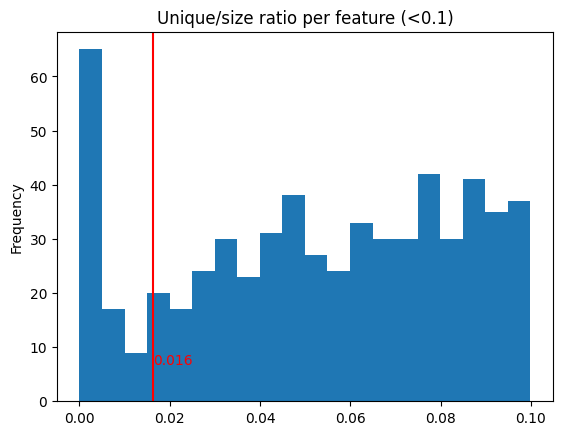

In [4]:
plot_unique_value_hist(ann_df, unique_ratio_cutoff = 0.1, features="Cells_Count")

#### List metadata stats

In [5]:
ann_df.filter(regex="^Metadata_").nunique()

Metadata_JCP2022             15096
Metadata_broad_sample        15096
Metadata_Name                15096
Metadata_Vector                  1
Metadata_Transcript          13552
Metadata_Symbol              12601
Metadata_NCBI_Gene_ID        12601
Metadata_Taxon_ID                2
Metadata_Gene_Description    12451
Metadata_Prot_Match            904
Metadata_Insert_Length        1667
Metadata_pert_type               2
Metadata_Source                  1
Metadata_Plate                 225
Metadata_Well                  368
Metadata_plate_map_name         45
Metadata_Batch                  12
dtype: int64

#### Remove rows with NaNs in features

In [6]:
ann_df[ann_df.filter(regex="^(?!Metadata_)").isnull().T.any()]

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
4027,JCP2022_904659,ccsbBroad304_04978,ORF007315.1_TRC304.1,pLX_304,NM_178232.4,HAPLN3,145864,9606,hyaluronan and proteoglycan link protein 3,100.0,...,64.606003,60.101002,60.910999,60.292000,60.720001,61.242001,63.160000,61.384998,63.092999,2021_07_12_Batch8
13972,JCP2022_905289,ccsbBroad304_05656,ORF006401.1_TRC304.1,pLX_304,NM_207118.3,GTF2H5,404672,9606,general transcription factor IIH subunit 5,100.0,...,58.566002,56.141998,56.303001,56.070999,56.668999,56.942001,58.181999,56.842999,58.549999,2021_07_12_Batch8
57561,JCP2022_913113,ccsbBroad304_14055,ORF013056.1_TRC304.1,pLX_304,NM_001306195.1,ARPP19,10776,9606,cAMP regulated phosphoprotein 19,99.1,...,121.300003,114.349998,115.099998,114.349998,115.180000,115.989998,119.370003,116.120003,119.330002,2021_08_02_Batch10


In [7]:
ann_df = drop_na_feature_rows(ann_df)
ann_df

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Batch
0,JCP2022_900002,ccsbBroad304_00001,ORF008415.1_TRC304.1,pLX_304,NM_001160173.3,NAT1,9,9606,N-acetyltransferase 1,100.0,...,82.875999,76.996002,77.473999,76.582001,77.233002,78.186996,80.055000,77.632004,79.955002,2021_06_21_Batch7
1,JCP2022_900011,ccsbBroad304_00013,ORF009063.1_TRC304.1,pLX_304,NM_001612.6,ACRV1,56,9606,acrosomal vesicle protein 1,100.0,...,93.607002,88.196999,89.211998,88.081001,89.154999,89.897003,92.719002,89.843002,92.597000,2021_06_21_Batch7
2,JCP2022_900033,ccsbBroad304_00037,ORF015627.1_TRC304.1,pLX_304,NM_001136.5,AGER,177,9606,advanced glycosylation end-product specific re...,100.0,...,133.380005,126.150002,127.250000,125.769997,127.250000,128.429993,131.880005,127.940002,131.960007,2021_06_21_Batch7
3,JCP2022_900063,ccsbBroad304_00069,ORF005433.1_TRC304.1,pLX_304,NM_001153.5,ANXA4,307,9606,annexin A4,100.0,...,84.871002,80.910004,81.814003,80.850998,81.926003,82.567001,85.179001,82.646004,85.292999,2021_06_21_Batch7
4,JCP2022_900084,ccsbBroad304_00091,ORF014376.1_TRC304.1,pLX_304,NM_001651.4,AQP5,362,9606,aquaporin 5,100.0,...,91.669998,87.241997,87.132004,86.538002,87.476997,88.224998,90.223000,87.663002,90.227997,2021_06_21_Batch7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79555,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,71.441002,66.777000,67.111000,66.614998,66.950996,67.466003,69.115997,67.341003,69.023003,2021_08_30_Batch13
79556,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,76.763000,72.568001,73.039001,72.873001,73.301003,73.550003,75.428001,73.696999,75.563004,2021_08_30_Batch13
79557,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,91.638000,86.575996,87.012001,86.803001,87.361000,87.459999,89.482002,87.972000,90.033997,2021_08_30_Batch13
79558,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,47.766998,45.113998,45.214001,45.137001,45.473999,45.556000,46.622002,45.544998,46.728001,2021_08_30_Batch13


#### Save filtered profiles with metadata

In [8]:
ann_df.to_parquet("output/raw_filtered_profiles.parquet", index=False)

#### Make sure no metadata columns weren't matched when merging

In [9]:
# list features ending with either "_x" or "_y", case insensitive
ann_df.columns[ann_df.columns.str.contains("(_x|_y)$", case=False)]

/var/folders/41/1jdfcmfs0gx7qwx9d31rtxgr0000gq/T/ipykernel_68348/3356552406.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ann_df.columns[ann_df.columns.str.contains("(_x|_y)$", case=False)]


Index(['Cells_AreaShape_BoundingBoxMaximum_X',
       'Cells_AreaShape_BoundingBoxMaximum_Y',
       'Cells_AreaShape_BoundingBoxMinimum_X',
       'Cells_AreaShape_BoundingBoxMinimum_Y', 'Cells_AreaShape_Center_X',
       'Cells_AreaShape_Center_Y', 'Cytoplasm_AreaShape_BoundingBoxMaximum_X',
       'Cytoplasm_AreaShape_BoundingBoxMaximum_Y',
       'Cytoplasm_AreaShape_BoundingBoxMinimum_X',
       'Cytoplasm_AreaShape_BoundingBoxMinimum_Y',
       'Cytoplasm_AreaShape_Center_X', 'Cytoplasm_AreaShape_Center_Y',
       'Nuclei_AreaShape_BoundingBoxMaximum_X',
       'Nuclei_AreaShape_BoundingBoxMaximum_Y',
       'Nuclei_AreaShape_BoundingBoxMinimum_X',
       'Nuclei_AreaShape_BoundingBoxMinimum_Y', 'Nuclei_AreaShape_Center_X',
       'Nuclei_AreaShape_Center_Y', 'Nuclei_Location_Center_X',
       'Nuclei_Location_Center_Y'],
      dtype='object')